In [18]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF

import Bgolearn.BGOsampling as BGOS 

In [19]:
def True_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8
    return Y

In [20]:
data = pd.read_csv('data.csv')
data_matrix = data.iloc[:,:-1]
Measured_response = data.iloc[:,-1]

## design virtual samples

In [21]:
virtual_samples = np.linspace(0,11,100)

## define a callable Kriging model and sampling function

In [28]:
inherent_noise_std = 0.2
guessed_noise_std = 0.3


def Sam_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8 + np.random.normal(loc=0.0, scale=inherent_noise_std, size=None)
    return Y


class Kriging_model(object):
    def fit_pre(self,xtrain,ytrain,xtest):
        # instantiated model
        kernel = RBF() 
        mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = guessed_noise_std**2).fit(xtrain,ytrain)
        # defined the attribute's outputs
        mean,std = mdoel.predict(xtest,return_std=True)
        return mean,std    

## instantiate Bgolearn

In [29]:
Bgolearn = BGOS.Bgolearn()
method_name = 'AEI'

current optimal is : 4.441054350424448
The next datum recomended by Augmented_EI : 
 x =  [8.33333333]
1-th iteration 
 new added datum: [8.3, 3.7291]


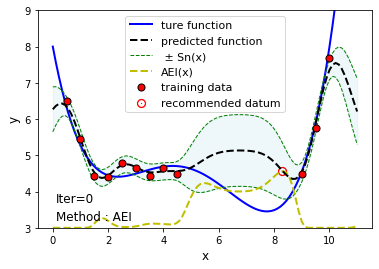

current optimal is : 3.6128547454480766
The next datum recomended by Augmented_EI : 
 x =  [7.55555556]
2-th iteration 
 new added datum: [7.6, 3.2432]


<Figure size 432x288 with 0 Axes>

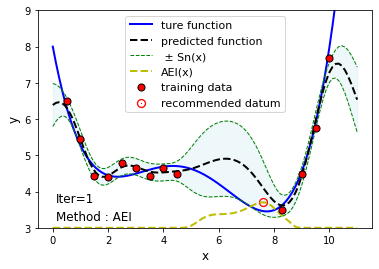

<Figure size 432x288 with 0 Axes>

In [30]:
data = pd.read_csv('data.csv')
data_in = copy.deepcopy(np.array(data))
for i in range(500):
    data_matrix = data_in[:,:-1]
    Measured_response = data_in[:,-1]
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix,Measured_response,virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.Augmented_EI(alpha = 1, tao = guessed_noise_std)*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))

    data_in = np.row_stack((data_in,[round(recommend,1),round(Sam_function(round(recommend,1)),4)]))
    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([round(recommend,1),round(Sam_function(round(recommend,1)),4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum")  
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-noise_{noise}-{num}.png'.format(name = method_name,noise = guessed_noise_std,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break